In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_format='retina'

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import ROOT, uproot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from time import time
import math

In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

Welcome to JupyROOT 6.18/04


In [3]:
def upsample(sample, scale):
    if scale > 0:
        sample = np.vstack([sample]*scale)
    else:
        sample = sample
    return sample

In [5]:
input_branches = ['br_njets', 'br_nleptons', 'br_nbjets', 'br_scalar_ht',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_met',
       'br_met_phi', 'br_sphericity', 'br_aplanarity', 'br_fox_wolfram_1',
       'br_fox_wolfram_2', 'br_fox_wolfram_3', 'br_fox_wolfram_4']

df_signal = uproot.open("/mnt/harddisk4/scratch/signal_dtG1_flat.root")["outtree"].pandas.df(input_branches)
df_dyjets = uproot.open("/mnt/harddisk4/scratch/dyjets_flat_30M.root")["outtree"].pandas.df(input_branches)
df_wjets  = uproot.open("/mnt/harddisk4/scratch/wjets_flat_10M.root")["outtree"].pandas.df(input_branches)
df_single_top  = uproot.open("/mnt/harddisk4/scratch/single_top_merged_flat.root")["outtree"].pandas.df(input_branches)
print(df_signal.keys())
print("n_signal:", len(df_signal), "n_dyjets:", len(df_dyjets), "n_wjets:", len(df_wjets), "n_single_top", len(df_single_top))

Index(['br_njets', 'br_nleptons', 'br_nbjets', 'br_scalar_ht', 'br_jet_pt_1',
       'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_met', 'br_met_phi',
       'br_sphericity', 'br_aplanarity', 'br_fox_wolfram_1',
       'br_fox_wolfram_2', 'br_fox_wolfram_3', 'br_fox_wolfram_4'],
      dtype='object')
n_signal: 205226 n_dyjets: 918 n_wjets: 161 n_single_top 841751


In [6]:
x_signal = df_signal.values
y_signal = np.full(len(x_signal) , 1)
x_dyjets = df_dyjets.values
x_wjets  = df_wjets.values
upsample_scale = 20
x_single_top  = df_single_top.values
x_wjets  = upsample(x_wjets, upsample_scale)
x_dyjets = upsample(x_dyjets, int(upsample_scale*(len(x_wjets)/len(x_dyjets))))
n_min    = min(len(x_dyjets), len(x_wjets), len(x_single_top))
x_bkg    = np.concatenate((x_dyjets[0:3*n_min], x_wjets[0:n_min], x_single_top[0:n_min]), axis=0)
y_bkg    = np.full(len(x_bkg) , 0)
print(n_min)

3220


In [7]:
x_sig_train, x_sig_test, y_sig_train, y_sig_test = train_test_split(x_signal, y_signal, test_size=0.5, random_state=20)
x_bkg_train, x_bkg_test, y_bkg_train, y_bkg_test = train_test_split(x_bkg, y_bkg, test_size=0.5, random_state=20)

x_train = np.concatenate((x_sig_train[0:len(x_bkg_train)], x_bkg_train), axis=0)
y_train = np.concatenate((y_sig_train[0:len(y_bkg_train)], y_bkg_train), axis=0)

x_test = np.concatenate((x_sig_test[0:len(x_bkg_train)], x_bkg_test), axis=0)
y_test = np.concatenate((y_sig_test[0:len(y_bkg_train)], y_bkg_test), axis=0)
                                  
scaler  = preprocessing.StandardScaler().fit(np.concatenate((x_train, x_test), axis=0))
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [8]:
print("training for", len(x_train), "events;", "testing for",  len(x_test), "events")

training for 16100 events; testing for 16100 events


In [9]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=1)

In [10]:
bdt.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [11]:
from sklearn.metrics import classification_report, roc_auc_score
y_predicted = bdt.predict(x_test)
print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(x_test))))

              precision    recall  f1-score   support

  background       0.81      0.88      0.84      8050
      signal       0.87      0.80      0.83      8050

    accuracy                           0.84     16100
   macro avg       0.84      0.84      0.84     16100
weighted avg       0.84      0.84      0.84     16100

Area under ROC curve: 0.8368


In [12]:
np.sum(abs(abs(y_predicted-y_test)-1))/len(y_predicted)

0.836832298136646

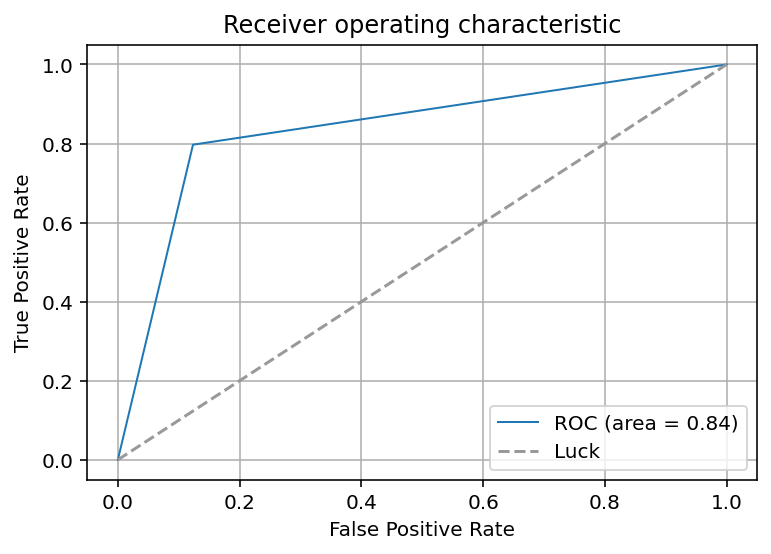

In [13]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(x_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

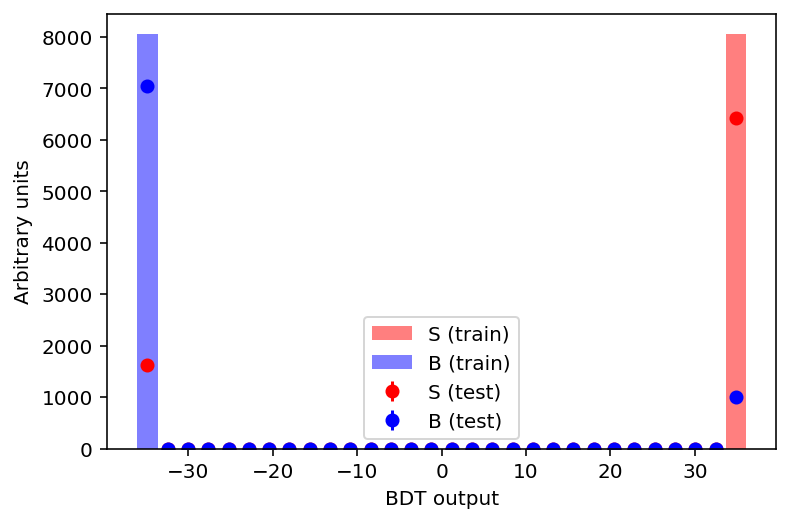

In [14]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled',
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, x_train, y_train, x_test, y_test)